## 4. Evaluation Metrics for Bank Marketing Dataset

### 4.1 Data Preperation

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv -O lead_scoring.csv

--2025-10-21 14:36:48--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘lead_scoring.csv’

lead_scoring.csv    100%[===================>]  78.98K  --.-KB/s    in 0.03s   

2025-10-21 14:36:50 (3.02 MB/s) - ‘lead_scoring.csv’ saved [80876/80876]



In [3]:
df = pd.read_csv("lead_scoring.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [5]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [6]:
df['converted'] = df['converted'].astype(int)

In [7]:
#Numerical and Categorical features
features = df.drop(columns=['converted'])
numerical_features = features.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = features.select_dtypes(include=['object', 'category']).columns.tolist()

In [8]:
#Fill missing values with 0 and NA
df[numerical_features] = df[numerical_features].fillna(0.0)
df[categorical_features] = df[categorical_features].fillna('NA')

In [10]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [11]:
#Split the data with random_state=1
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

### 4.2 Q1: ROC AUC feature importance

In [12]:
from sklearn.metrics import roc_auc_score

y_train = df_train['converted'].values

aucs = {}
for col in numerical_features:
    scores = df_train[col].values
    auc = roc_auc_score(y_train, scores)
    if auc < 0.5:
        auc = roc_auc_score(y_train, -scores)
    aucs[col] = auc

sorted(aucs.items(), key=lambda x: x[1], reverse=True)

[('number_of_courses_viewed', 0.7635680590007088),
 ('interaction_count', 0.738270176293409),
 ('lead_score', 0.6144993577250176),
 ('annual_income', 0.5519578313253012)]

Q1: number_of_course_viewed

### 4.3 Q2: Logistic Regression

In [13]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [14]:
#prepare the data
y_train = df_train['converted'].values
y_val = df_val['converted'].values

train_dicts = df_train.drop('converted', axis=1).to_dict(orient='records')
val_dicts = df_val.drop('converted', axis=1).to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [15]:
#Train the model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [16]:
#Predict probabilities for validation set
y_pred = model.predict_proba(X_val)[:,1]

roc_auc = roc_auc_score(y_val, y_pred)
roc_auc

0.8171316268814112

### 4.4 Q3: Precision and Recall

In [17]:
from sklearn.metrics import precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

In [20]:
thresholds = np.arange(0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    preds = (y_pred >= t).astype(int)
    precisions.append(precision_score(y_val, preds))
    recalls.append(recall_score(y_val, preds))

/home/timmy/machine-learning-zoom-camp/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/timmy/machine-learning-zoom-camp/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/timmy/machine-learning-zoom-camp/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

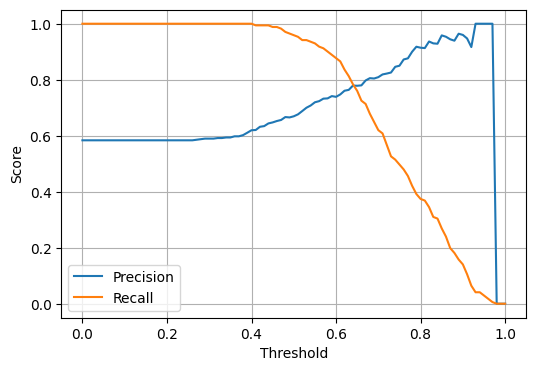

In [21]:
plt.figure(figsize=(6, 4))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
precisions = np.array(precisions)
recalls = np.array(recalls)

mask = (precisions > 0) & (recalls > 0)
diff = np.abs(precisions[mask] - recalls[mask])
best_idx = np.argmin(diff)
best_threshold = thresholds[mask][best_idx]
best_threshold

np.float64(0.64)

Q3: 0.545

### 4.5 Q4: F-Score

In [30]:
import numpy as np

precisions_arr = np.array(precisions, dtype=float)
recalls_arr = np.array(recalls, dtype=float)

den = precisions_arr + recalls_arr
den[den == 0] = 1e-10

f1 = 2 * (precisions_arr * recalls_arr) / den
best_f1_idx = np.nanargmax(f1)
best_threshold_f1 = thresholds[best_f1_idx]
best_f1 = f1[best_f1_idx]

best_threshold_f1, best_f1

(np.float64(0.5700000000000001), np.float64(0.8124999999999999))

Q4: 0.54

### 4.6 Fold CV

In [32]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

In [34]:
df_ft = df_full_train.copy()
y_ft = df_ft['converted'].values
X_ft = df_ft.drop(columns=['converted'])

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(X_ft):
    X_train = X_ft.iloc[train_idx]
    X_va = X_ft.iloc[val_idx]
    y_train = y_ft[train_idx]
    y_val = y_ft[val_idx]

    dv = DictVectorizer(sparse=False)
    Xtr_dicts = X_train.to_dict(orient='records')
    Xva_dicts = X_va.to_dict(orient='records')

    X_train_enc = dv.fit_transform(Xtr_dicts)
    X_val_enc = dv.transform(Xva_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_enc, y_train)
    y_pred = model.predict_proba(X_val_enc)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)

print('CV AUC:', np.mean(scores))
print('CV AUC std:', np.std(scores))

CV AUC: 0.8221089148573075
CV AUC std: 0.03580711942905165


Q5: 0.06

### 4.7 Q6: Hyperparameter tuning

In [35]:
Cs = [0.000001, 0.001, 1]
results = []

for C in Cs:
    fold_scores = []

    for train_idx, val_idx in kfold.split(X_ft):
        X_train = X_ft.iloc[train_idx]
        X_va = X_ft.iloc[val_idx]
        y_train = y_ft[train_idx]
        y_val = y_ft[val_idx]

        dv = DictVectorizer(sparse=False)
        Xtr_dicts = X_train.to_dict(orient='records')
        Xva_dicts = X_va.to_dict(orient='records')

        X_train_enc = dv.fit_transform(Xtr_dicts)
        X_val_enc = dv.transform(Xva_dicts)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_enc, y_train)
        y_pred = model.predict_proba(X_val_enc)[:, 1]
        score = roc_auc_score(y_val, y_pred)
        fold_scores.append(score)
    
    mean_score = np.mean(fold_scores)
    std_score = np.std(fold_scores)
    results.append((C, round(mean_score, 3), round(std_score, 3)))
results

[(1e-06, np.float64(0.56), np.float64(0.024)),
 (0.001, np.float64(0.867), np.float64(0.029)),
 (1, np.float64(0.822), np.float64(0.036))]

Q6: 0.001